# RNN

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
class TimeSeriesData():
    
    def __init__(self, num_points, xmin, xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax - xmin)/num_points
        self.x_data = np.linspace(xmin, xmax, num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        # Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size, 1)
        # Convert to be on time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution))
        # Create batch time series on the x axis
        batch_ts = ts_start + np.arange(0.0, steps+1) * self.resolution
        # Create y data for time series from previous step
        y_batch = np.sin(batch_ts)
        # Formatting for RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1), batch_ts
        else:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)

In [7]:
ts_data = TimeSeriesData(250, 0, 10)

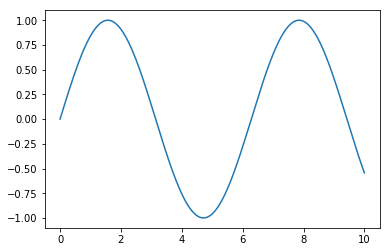

In [8]:
plt.plot(ts_data.x_data, ts_data.y_true)

In [9]:
num_time_steps = 30

In [10]:
y1, y2, ts = ts_data.next_batch(1, num_time_steps, True)

In [15]:
ts.flatten().shape

(31,)

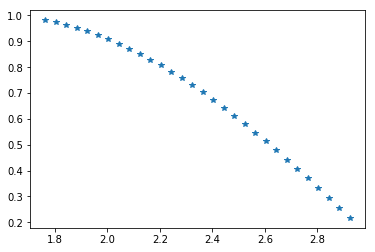

In [17]:
plt.plot(ts.flatten()[1:], y2.flatten(), "*")

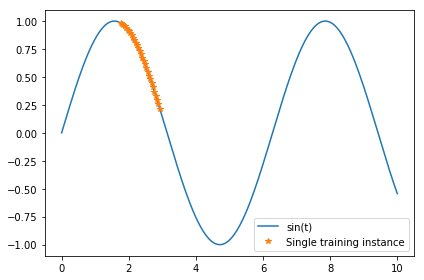

In [21]:
plt.plot(ts_data.x_data, ts_data.y_true, label='sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(), "*", label="Single training instance")
plt.legend()
plt.tight_layout()

In [24]:
# Training data
training_inst = np.linspace(5, 5+ts_data.resolution*(num_time_steps+1), num_time_steps+1)
training_inst

array([5.        , 5.04133333, 5.08266667, 5.124     , 5.16533333,
       5.20666667, 5.248     , 5.28933333, 5.33066667, 5.372     ,
       5.41333333, 5.45466667, 5.496     , 5.53733333, 5.57866667,
       5.62      , 5.66133333, 5.70266667, 5.744     , 5.78533333,
       5.82666667, 5.868     , 5.90933333, 5.95066667, 5.992     ,
       6.03333333, 6.07466667, 6.116     , 6.15733333, 6.19866667,
       6.24      ])

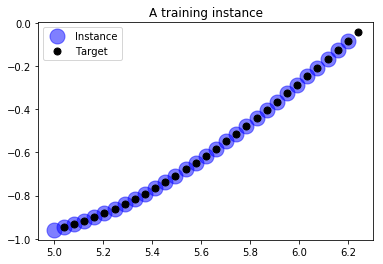

In [29]:
plt.title('A training instance')
plt.plot(training_inst[:-1], ts_data.ret_true(training_inst[:-1]), 'bo', markersize=15, alpha=0.5, label='Instance')
plt.plot(training_inst[1:], ts_data.ret_true(training_inst[1:]), 'ko', markersize=7, label='Target')
plt.legend()

# Creating the Model

In [30]:
tf.reset_default_graph()

In [31]:
num_inputs = 1
num_neurons = 100
num_outputs = 1
learning_rate = 0.0001
num_training_iterations = 2000
batch_size = 1

In [32]:
# Placeholders
x = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [33]:
# RNN cell layer
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu), 
    output_size=num_outputs)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [34]:
outputs, states = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


In [35]:
# MSE
loss = tf.reduce_mean(tf.square(outputs-y)) 

In [36]:
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [38]:
# Session
init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    for iteration in range(num_training_iterations):
        x_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict={x:x_batch, y:y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={x:x_batch, y:y_batch})
            print(iteration, "\tMSE", mse)
    saver.save(sess, "./rnn_time_series_model")

0 	MSE 0.13997659
100 	MSE 0.01592881
200 	MSE 0.020920359
300 	MSE 0.010120138
400 	MSE 0.0033729817
500 	MSE 0.012784006
600 	MSE 0.0007039088
700 	MSE 0.0071343454
800 	MSE 0.0018060437
900 	MSE 0.0018083995
1000 	MSE 0.006280305
1100 	MSE 0.002706649
1200 	MSE 0.00020646692
1300 	MSE 0.0025036824
1400 	MSE 0.01232264
1500 	MSE 0.0010762146
1600 	MSE 5.7524416e-05
1700 	MSE 0.0016377717
1800 	MSE 0.0013141462
1900 	MSE 0.0009126726


In [40]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")
    x_new = np.sin(np.array(training_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={x:x_new})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


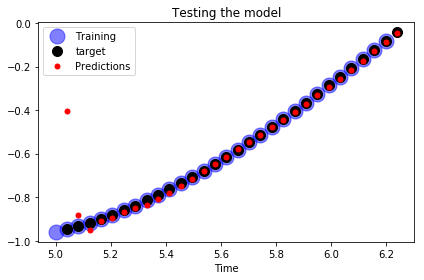

In [42]:
plt.title("Testing the model")
# Training instance
plt.plot(training_inst[:-1], np.sin(training_inst[:-1]), "bo", markersize=15, alpha=0.5, label='Training')
# Target to predict np.sin(training)
plt.plot(training_inst[1:], np.sin(training_inst[1:]), "ko", markersize=10, label='target')
# Prediction
plt.plot(training_inst[1:], y_pred[0,:,0], 'r.', markersize=10, label='Predictions')

plt.xlabel('Time')
plt.legend()
plt.tight_layout()